# **RNN Introduction**


## Importing required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
import seaborn as sns
import datetime as dt

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [2]:
df = pd.read_csv('D:\\Tuwaiq Academy\\Tuwaiq_Academy_T5_Week_5\\Week5LAB1\\Datasets\\traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

In [5]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
df.drop('ID', inplace=True, axis=1)
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [7]:
df['Junction'].value_counts()

Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64

In [8]:
df.shape

(48120, 3)

In [9]:
df['Vehicles'].unique()

array([ 15,  13,  10,   7,   9,   6,   8,  11,  12,  17,  16,  20,  19,
        14,  22,  32,  31,  35,  26,  34,  30,  27,  24,  29,  21,  18,
        33,  28,  25,  23,  40,  38,  36,  48,  43,  41,  37,  39,  42,
        44,  47,  50,  45,  46,  70,  54,  52,  55,  49,  58,  64,  62,
        51,  53,  61,  56,  57,  63,  59,  60,  67,  76,  79,  66,  65,
        68,  69,  86,  73,  77,  74,  71,  72,  78,   5,  81,  75,  80,
        82,  89,  83,  93,  91,  85,  90,  84,  87,  94,  92, 106,  98,
        88,  96, 120,  97, 104,  95, 100, 112, 103, 105, 143, 134, 135,
       141, 156, 110, 102,  99, 132, 124, 113, 109, 115, 101, 108, 114,
       107, 111, 136, 129, 118, 116, 123, 133, 128, 117, 121, 127, 140,
       126, 122, 119,   2,   4,   3,   1, 125, 180, 173, 162], dtype=int64)

In [10]:
df['Vehicles'].describe()

count    48120.000000
mean        22.791334
std         20.750063
min          1.000000
25%          9.000000
50%         15.000000
75%         29.000000
max        180.000000
Name: Vehicles, dtype: float64

In [11]:
df['DateTime'].describe()

count                            48120
mean     2016-09-19 06:03:56.109725696
min                2015-11-01 00:00:00
25%                2016-04-16 01:45:00
50%                2016-09-30 03:30:00
75%                2017-02-25 16:00:00
max                2017-06-30 23:00:00
Name: DateTime, dtype: object

In [12]:
df['Hour'] = df['DateTime'].dt.hour
df.head()

,DateTime,Junction,Vehicles,Hour
0,2015-11-01 00:00:00,1,15,0
1,2015-11-01 01:00:00,1,13,1
2,2015-11-01 02:00:00,1,10,2
3,2015-11-01 03:00:00,1,7,3
4,2015-11-01 04:00:00,1,9,4


In [13]:
df['Date'] = df['DateTime'].dt.date
df.head()

,DateTime,Junction,Vehicles,Hour,Date
0,2015-11-01 00:00:00,1,15,0,2015-11-01
1,2015-11-01 01:00:00,1,13,1,2015-11-01
2,2015-11-01 02:00:00,1,10,2,2015-11-01
3,2015-11-01 03:00:00,1,7,3,2015-11-01
4,2015-11-01 04:00:00,1,9,4,2015-11-01


In [22]:
df.drop('DateTime', axis=1, inplace=True)
df.head()

,Junction,Date,EM,M,AN,N
0,1,2015-11-01,15,0,0,0
1,1,2015-11-01,13,0,0,0
2,1,2015-11-01,10,0,0,0
3,1,2015-11-01,7,0,0,0
4,1,2015-11-01,9,0,0,0


In [23]:
df['Hour']

KeyError: 'Hour'

In [ ]:
def count_Veh(df):
    # Initialize columns to store the sum for each period
    df['EM'] = 0
    df['M'] = 0
    df['AN'] = 0
    df['N'] = 0
    
    # Apply conditions to assign sums based on the hour
    df.loc[(df['Hour'] >= 0) & (df['Hour'] < 6), 'EM'] = df['Vehicles']
    df.loc[(df['Hour'] >= 6) & (df['Hour'] < 12), 'M'] = df['Vehicles']
    df.loc[(df['Hour'] >= 12) & (df['Hour'] < 18), 'AN'] = df['Vehicles']
    df.loc[(df['Hour'] >= 18) & (df['Hour'] < 24), 'N'] = df['Vehicles']

In [ ]:
count_Veh(df)
df

,DateTime,Junction,Vehicles,Hour,Date,EM,M,AN,N
0,2015-11-01 00:00:00,1,15,0,2015-11-01,15,0,0,0
1,2015-11-01 01:00:00,1,13,1,2015-11-01,13,0,0,0
2,2015-11-01 02:00:00,1,10,2,2015-11-01,10,0,0,0
3,2015-11-01 03:00:00,1,7,3,2015-11-01,7,0,0,0
4,2015-11-01 04:00:00,1,9,4,2015-11-01,9,0,0,0
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,19,2017-06-30,0,0,0,11
48116,2017-06-30 20:00:00,4,30,20,2017-06-30,0,0,0,30
48117,2017-06-30 21:00:00,4,16,21,2017-06-30,0,0,0,16
48118,2017-06-30 22:00:00,4,22,22,2017-06-30,0,0,0,22


In [24]:
df.drop(['Hour', 'Vehicles'], axis=1, inplace=True)
df

KeyError: "['Hour', 'Vehicles'] not found in axis"

In [25]:
df = df.groupby(['Junction', 'Date']).sum().reset_index()

# Display the result
print(df)

      Junction        Date  EM    M   AN    N
0            1  2015-11-01  60   72   87  108
1            1  2015-11-02  75  124  179  168
2            1  2015-11-03  93  134  168  149
3            1  2015-11-04  84  112  154  148
4            1  2015-11-05  92  102  137  133
...        ...         ...  ..  ...  ...  ...
2000         4  2017-06-26  27   39   60   55
2001         4  2017-06-27  25   35  101   64
2002         4  2017-06-28  33   51   86  106
2003         4  2017-06-29  49   62  106   79
2004         4  2017-06-30  37   51   76  108

[2005 rows x 6 columns]


In [26]:
df.drop(['EM', 'M'], inplace=True, axis=1)
df

,Junction,Date,AN,N
0,1,2015-11-01,87,108
1,1,2015-11-02,179,168
2,1,2015-11-03,168,149
3,1,2015-11-04,154,148
4,1,2015-11-05,137,133
...,...,...,...,...
2000,4,2017-06-26,60,55
2001,4,2017-06-27,101,64
2002,4,2017-06-28,86,106
2003,4,2017-06-29,106,79


In [27]:
def specific_data(junction, start, end):
    junction_data = df[df['Junction'] == junction]
    date_filtered_data = junction_data[(junction_data['Date'] > start) & (junction_data['Date'] < end)]
    return date_filtered_data

In [28]:

junction_number = random.choice(df['Junction'].unique().tolist())

start_date=dt.date(2015,11,1)
end_date=dt.date(2017,6,30)


specific_df = specific_data(junction_number, start_date, end_date)

In [29]:
specific_df.head()

,Junction,Date,AN,N
1217,3,2015-11-02,45,60
1218,3,2015-11-03,43,35
1219,3,2015-11-04,41,34
1220,3,2015-11-05,32,33
1221,3,2015-11-06,28,33


In [30]:
specific_df.shape

(606, 4)

## Visualization

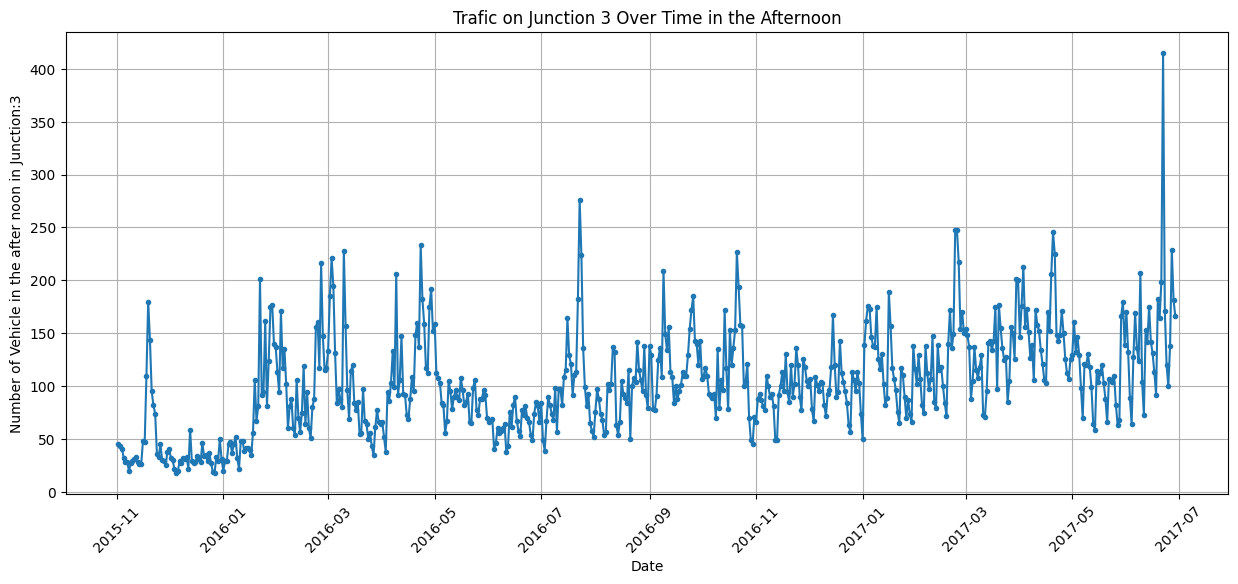

In [31]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['AN'], marker='.')
plt.title(f'Trafic on Junction {junction_number} Over Time in the Afternoon')
plt.xlabel('Date')
plt.ylabel(f'Number of Vehicle in the after noon in Junction:{junction_number}')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

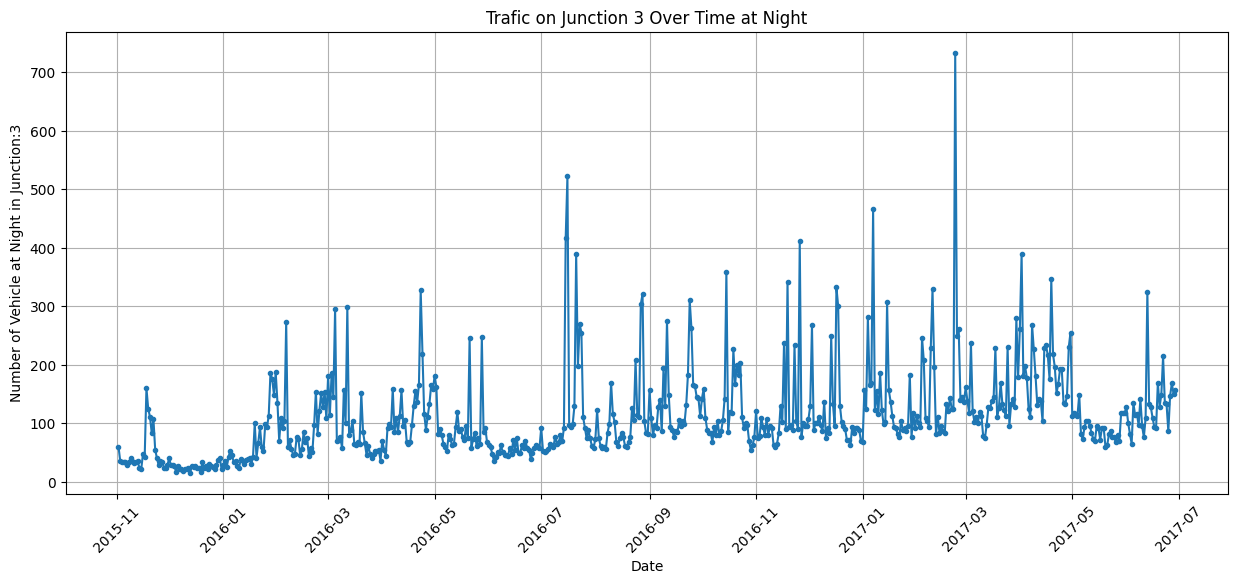

In [32]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['N'], marker='.')
plt.title(f'Trafic on Junction {junction_number} Over Time at Night')
plt.xlabel('Date')
plt.ylabel(f'Number of Vehicle at Night in Junction:{junction_number}')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

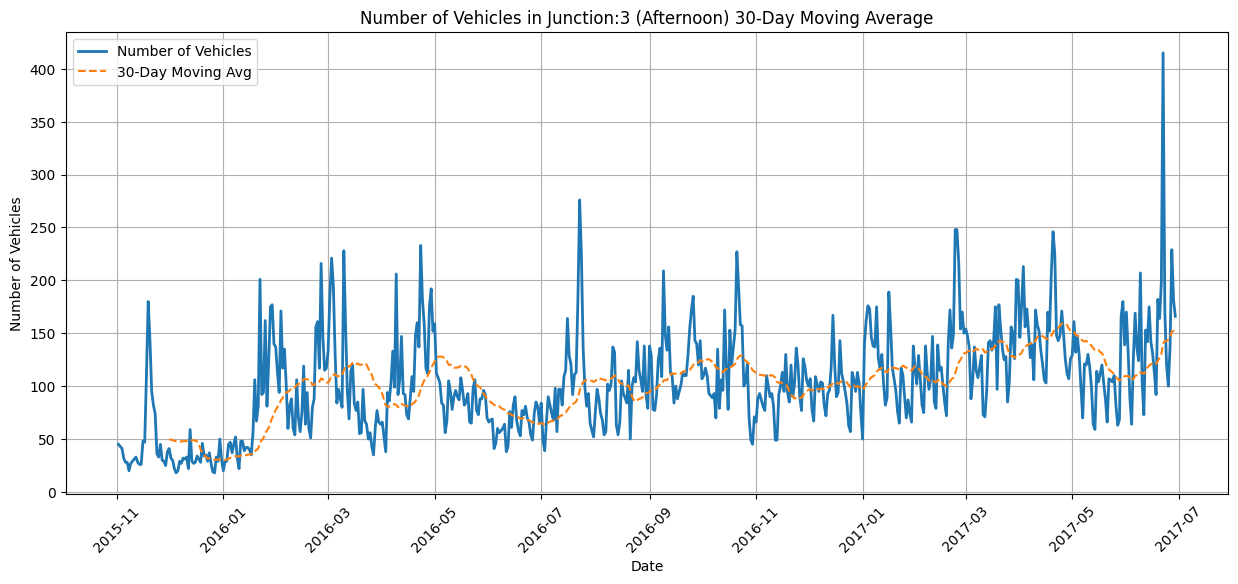

In [33]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['AN'], label='Number of Vehicles', linewidth=2)
plt.plot(specific_df['Date'], specific_df['AN'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Number of Vehicles in Junction:{junction_number} (Afternoon) {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

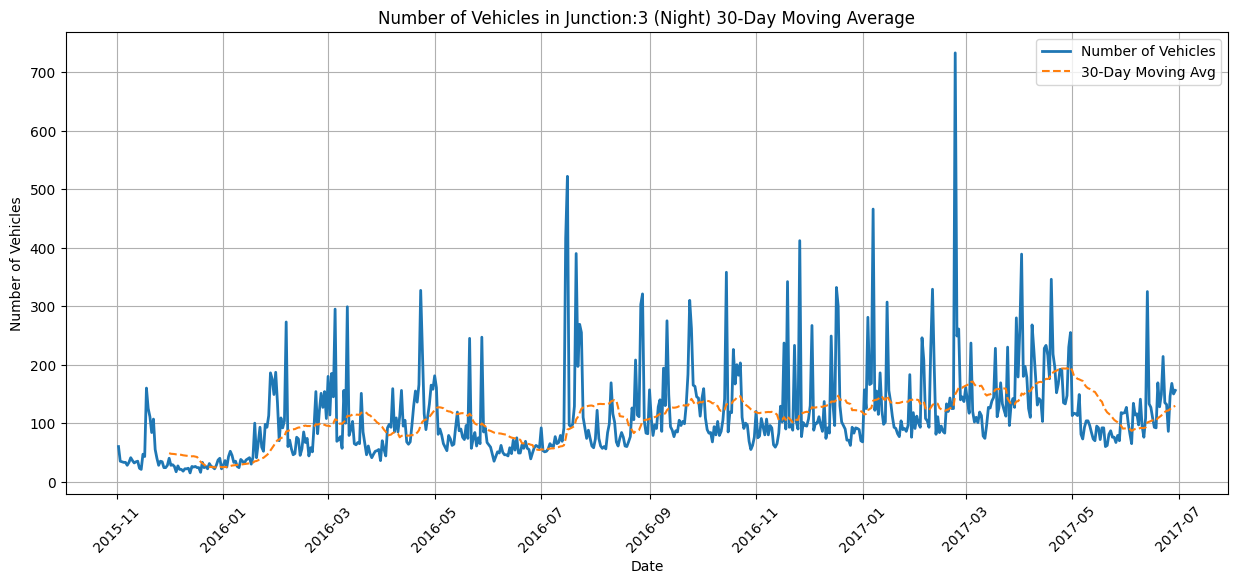

In [34]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['N'], label='Number of Vehicles', linewidth=2)
plt.plot(specific_df['Date'], specific_df['N'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Number of Vehicles in Junction:{junction_number} (Night) {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

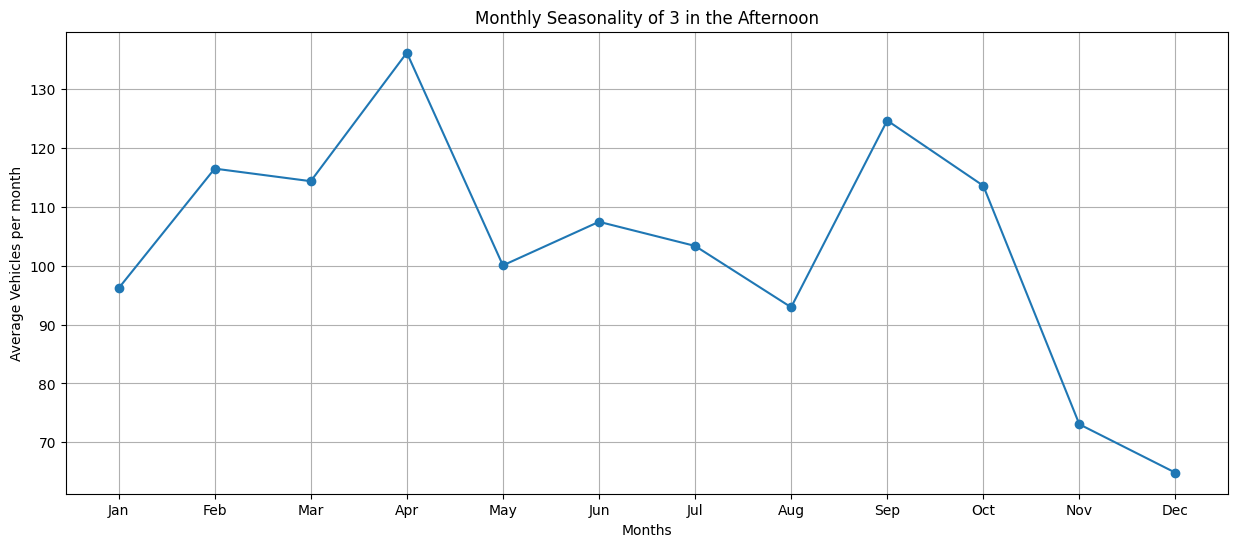

In [35]:
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['AN'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {junction_number} in the Afternoon')
plt.xlabel('Months')
plt.ylabel('Average Vehicles per month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

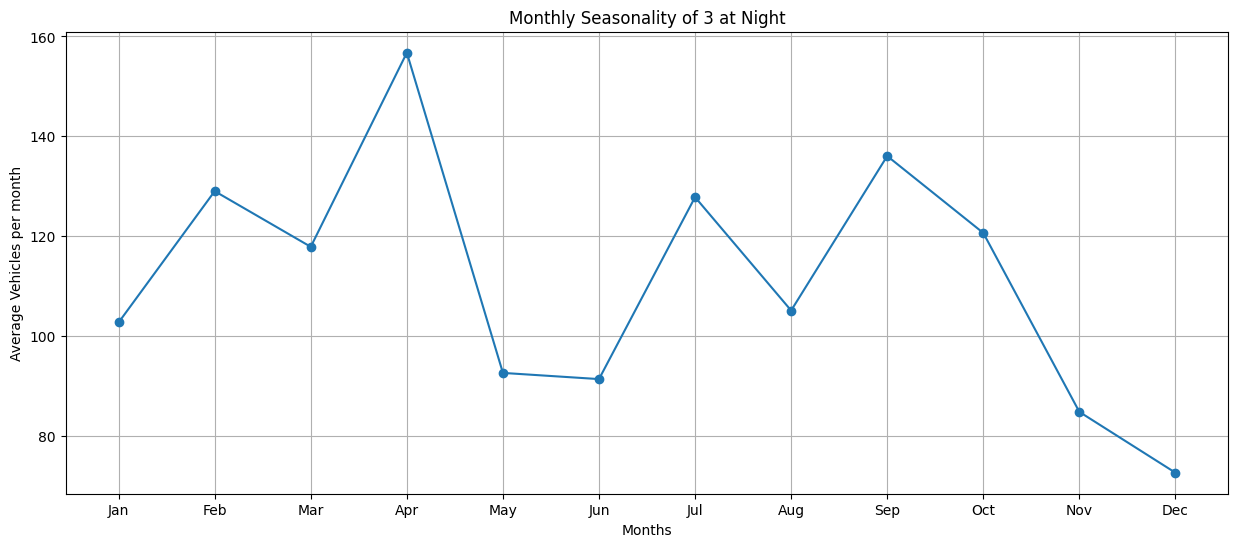

In [36]:
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['N'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {junction_number} at Night')
plt.xlabel('Months')
plt.ylabel('Average Vehicles per month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [37]:
new_df = specific_df.reset_index()['AN']

In [38]:
new_df

0       45
1       43
2       41
3       32
4       28
      ... 
601    100
602    138
603    229
604    181
605    166
Name: AN, Length: 606, dtype: int64

In [39]:
scaler = MinMaxScaler()
scaled_df=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [40]:
scaled_df.shape

(606, 1)

## Split the data into train and test

In [41]:
train_size = int(len(scaled_df) * 0.8)
train_size

484

In [42]:
scaled_df.shape

(606, 1)

In [43]:
train_data, test_data = scaled_df[:train_size], scaled_df[train_size:]

In [44]:
n_past = 20


X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [45]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(464, 20)
(464,)


Testing set size:-
(102, 20)
(102,)


(None, None)

In [46]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

## Modeling


In [59]:

model = Sequential([
    layers.SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    layers.Dropout(0.2),
    layers.SimpleRNN(units=100, return_sequences=True),
    layers.Dropout(0.2),
    layers.SimpleRNN(units=50),
    layers.Dropout(0.3),
    layers.Dense(units=1),
])

model.summary()

C:\Users\abo_O\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 20, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 100)        │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,901 (148.05 KB)

 Trainable params: 37,901 (148.05 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [61]:
checkpoint = ModelCheckpoint(filepath='weight.keras', save_best_only= True)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs= 50,
          batch_size=16,
          verbose=1,
          callbacks=[checkpoint, early_stopping])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.5336 - val_loss: 0.0341
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2681 - val_loss: 0.0236
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1729 - val_loss: 0.0153
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0970 - val_loss: 0.0206
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0787 - val_loss: 0.0149
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0564 - val_loss: 0.0141
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0403 - val_loss: 0.0116
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0392 - val_loss: 0.0137
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0314 - val_loss: 0.0113
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0276 - val_loss: 0.0110
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0237 - val_loss: 0.0127
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [62]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [63]:
# Check the shape of train_predict and test_predict
print("train_predict shape:", train_predict.shape)
print("test_predict shape:", test_predict.shape)

train_predict shape: (464, 1)
test_predict shape: (102, 1)


In [64]:

# # Reshape if necessary. Assuming predictions are in the shape (samples, time_steps, features)
# if len(train_predict.shape) == 3:
#     train_predict = train_predict[:, -1, :]  # Take the last time step prediction if needed
# if len(test_predict.shape) == 3:
#     test_predict = test_predict[:, -1, :]  # Take the last time step prediction if needed

# # Ensure the predictions are 2D before inverse_transform
# train_predict_2d = train_predict.reshape(-1, 1)
# test_predict_2d = test_predict.reshape(-1, 1)

# # Inverse transform
# train_predict = scaler.inverse_transform(train_predict_2d)
# test_predict = scaler.inverse_transform(test_predict_2d)


In [65]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [66]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

105.77590108179322
140.3229159396756


## Visualization of results


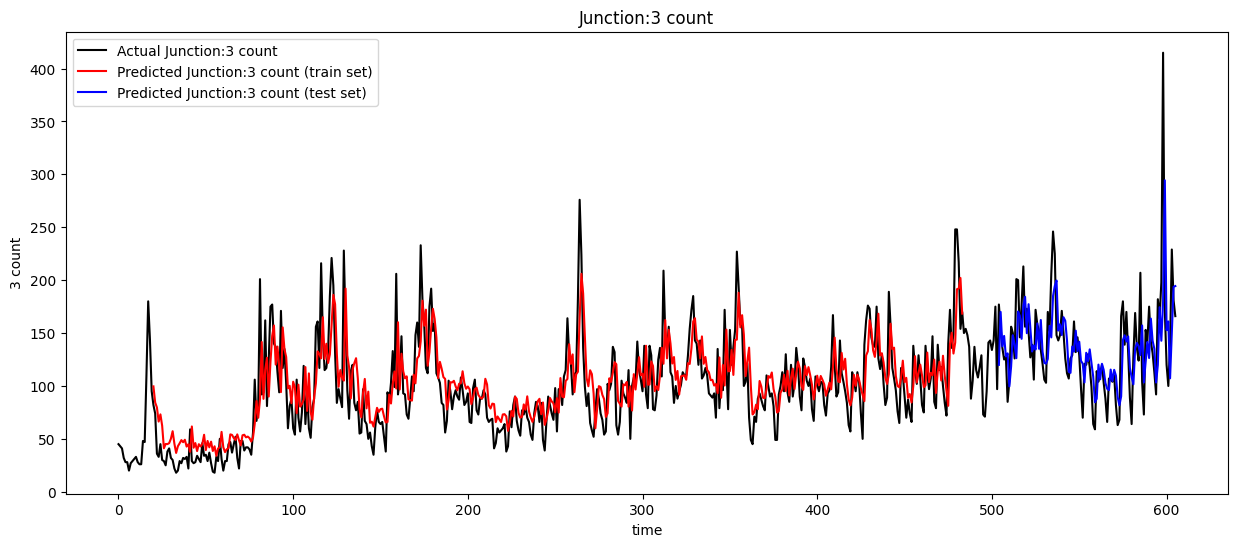

In [67]:

look_back = 20

# Ensure the arrays are of type float
trainPredPlot = np.empty_like(new_df, dtype=float)
trainPredPlot[:] = np.nan

trainPredPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(new_df, dtype=float)
testPredictPlot[:] = np.nan

test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(scaled_df)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual Junction:{junction_number} count")
plt.plot(trainPredPlot, color='red', label=f"Predicted Junction:{junction_number} count (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted Junction:{junction_number} count (test set)")

plt.title(f"Junction:{junction_number} count")
plt.xlabel("time")
plt.ylabel(f"Vehicles Count on Junction:{junction_number}")
plt.legend()
plt.show()


In [68]:
# To predict for the next 10 days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):  # Predicting for the next 10 days
    next_day_prediction = model.predict(last_sequence)
    scalar_prediction = next_day_prediction[0, 0]  # Extract the scalar value
    predictions_next_10_days.append(scalar_prediction)  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1] = scalar_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Count = {prediction[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions for the next 10 days:
Day 1: Predicted Count = 194.42373657226562
Day 2: Predicted Count = 185.037353515625
Day 3: Predicted Count = 130.19447326660156
Day 4: Predicted Count = 133.42893981933594
Day 5: Predicted Count = 155.43270874023438
Day 6: Predicted Count = 150.5819549560547
Day 7: Predicted Count = 149.6991424560547
Day 8: Predicted Count = 166.6667022705078
Day 9: Predicted Count = 143.65859985351562
Day 10: Predicted Count = 132.96983337402344


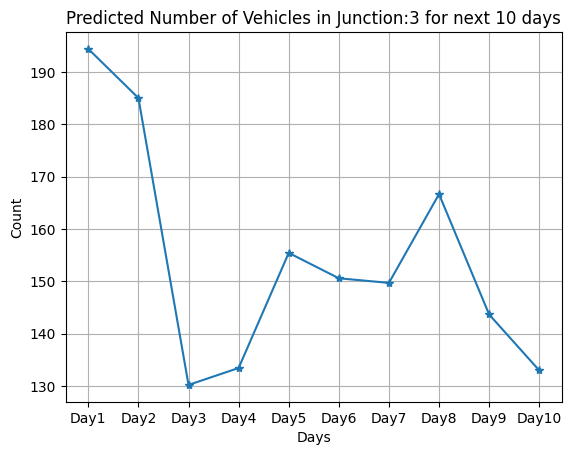

In [69]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted Number of Vehicles in Junction:{junction_number} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Count')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()